<strong><b><font size="5">Análisis de series de tiempo</font></b></strong>

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importar datos
- Dataset: International airline passengers
- Unidades: miles

In [3]:
df = pd.read_csv('international-airline-passengers.csv',header=None)

In [4]:
df.columns = ['year','passengers']

In [5]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [6]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [8]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [9]:
df.shape

(144, 2)

# Pre-procesamiento de datos y visualización

__Convertir a formato "datetime":__

In [10]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

__Establecer a la fecha como índice:__

In [11]:
y = df.set_index('year')

In [12]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [13]:
y.isnull().sum()

passengers    0
dtype: int64

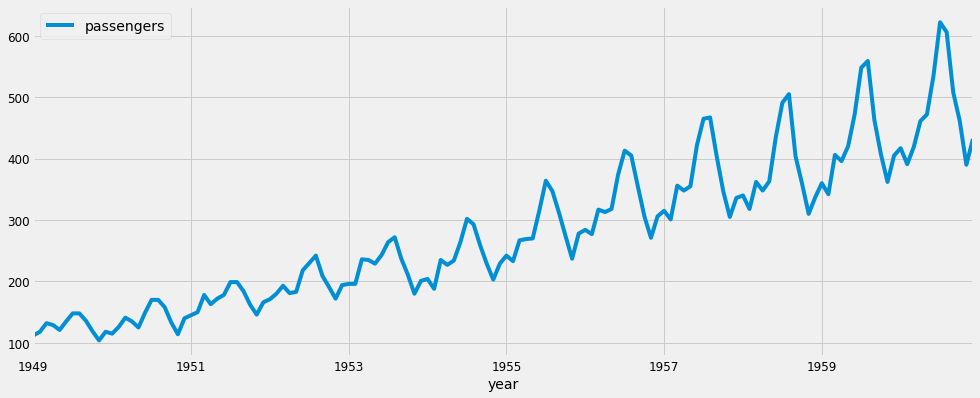

In [15]:
y.plot(figsize=(15, 6))
plt.show()

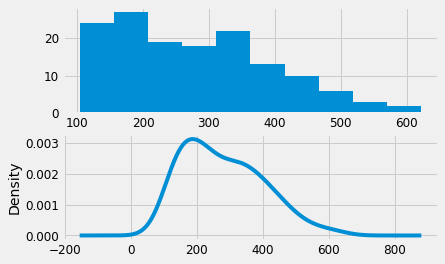

In [16]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

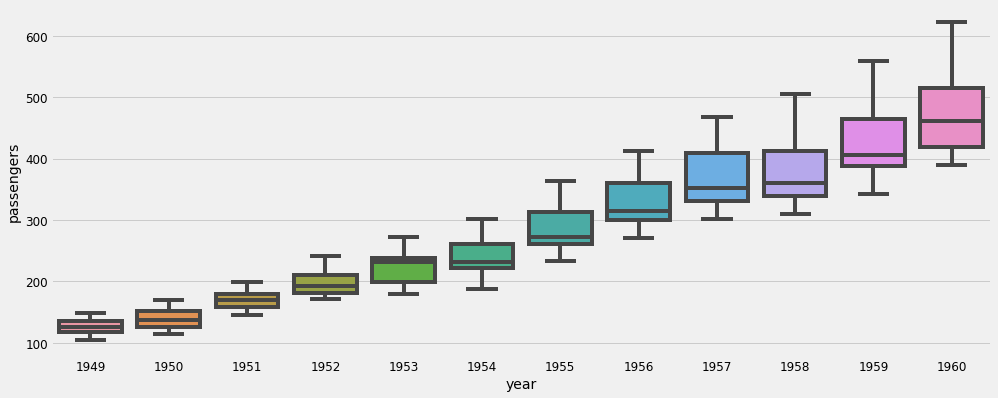

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

# Pruebas de estacionariedad

- __Gráficos ACF y PACF__: Si la serie de tiempo es estacionaria, los gráficos ACF / PACF mostrarán una __disminución rápida en la correlación__ después de una pequeña cantidad de retraso entre los puntos.
- __Estadísticos móviles__: Podemos trazar la media móvil o la varianza móvil y ver si varía con el tiempo. La media móvil / varianza es para cualquier instante "t", la media / varianza del último año, es decir, los últimos 12 meses.
- __Prueba Dickey-Fuller aumentada:__ Esta es una de las pruebas estadísticas para comprobar la estacionariedad. Aquí la hipótesis nula es que el la serie de tiempo no es estacionaria. Los resultados de la prueba comprenden una estadística de prueba y algunos valores críticos para los niveles de confianza de diferencia. Si la "estadística de prueba" es menor que el "valor crítico", podemos rechazar la hipótesis nula y decir que la serie es estacionaria. Consulte este artículo para obtener más detalles.

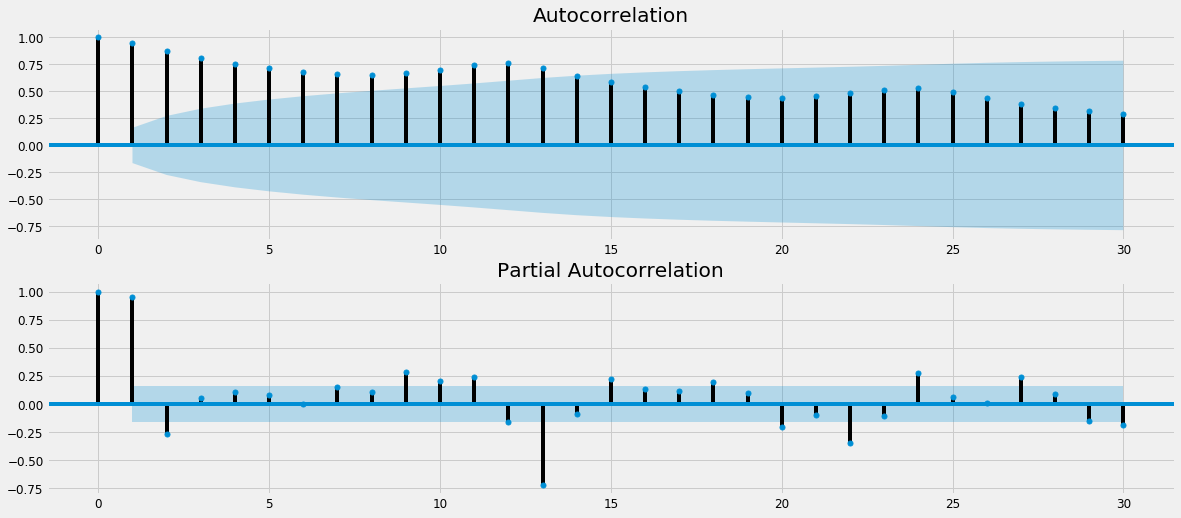

In [1045]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

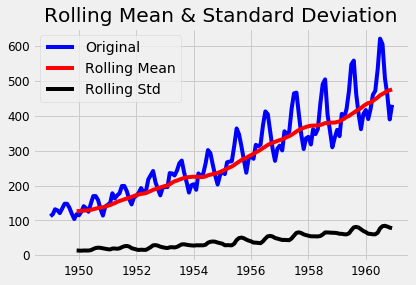

In [22]:
#Determing rolling statistics
rolmean = y.rolling(window=12).mean()
rolstd = y.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [37]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Hacer que las series de tiempo  sean estacionarias
Hay 2 razones principales detrás de la no estacionariedad de una serie de tiempo:

1. __Tendencia__: media variable con el tiempo. Por ejemplo, en este caso vimos que, en promedio, el número de pasajeros estaba creciendo con el tiempo.
2. __Seasonality__ - variaciones en períodos de tiempo específicos. por ejemplo, las personas pueden tener una tendencia a comprar automóviles en un mes en particular debido al incremento de pago o festivales.

### Transformaciones
- Podemos aplicar transformaciones que penalicen los valores más altos más que los valores más pequeños. Estos pueden tomar un registro, una raíz cuadrada, una raíz cúbica, etc. Tomemos aquí una transformación de registro para simplificar:

#### Log Scale Transformation

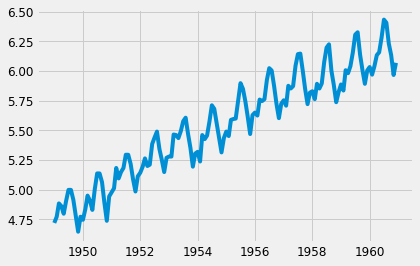

In [38]:
ts_log = np.log(y)
plt.plot(ts_log)

#### Otras transformaciones posibles:
- Exponential tranformation
- Box Cox transformation
- Square root transformation

### Técnicas de suavizado en series de tiempo
- Medias móviles

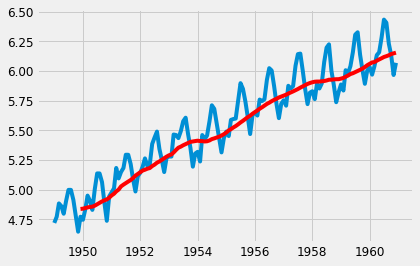

In [39]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [40]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

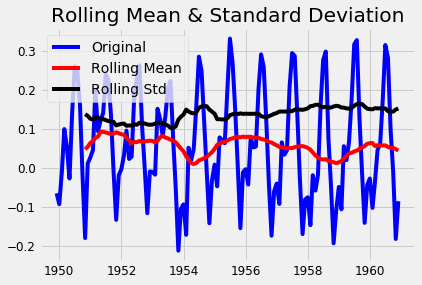

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [41]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Más técnicas para eliminar la estacionalidad y la tendencia
- Las técnicas simples de reducción de tendencias discutidas antes no funcionan en todos los casos, particularmente en los que tienen alta estacionalidad. 

#### Diferenciación
- En esta técnica, tomamos la diferencia de la observación en un instante particular con la del instante anterior.
- Diferenciación de primer orden en Pandas

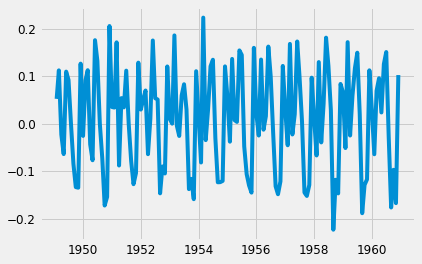

In [43]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

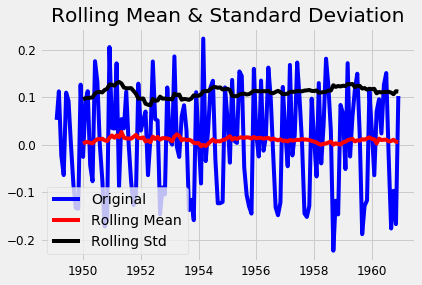

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [44]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

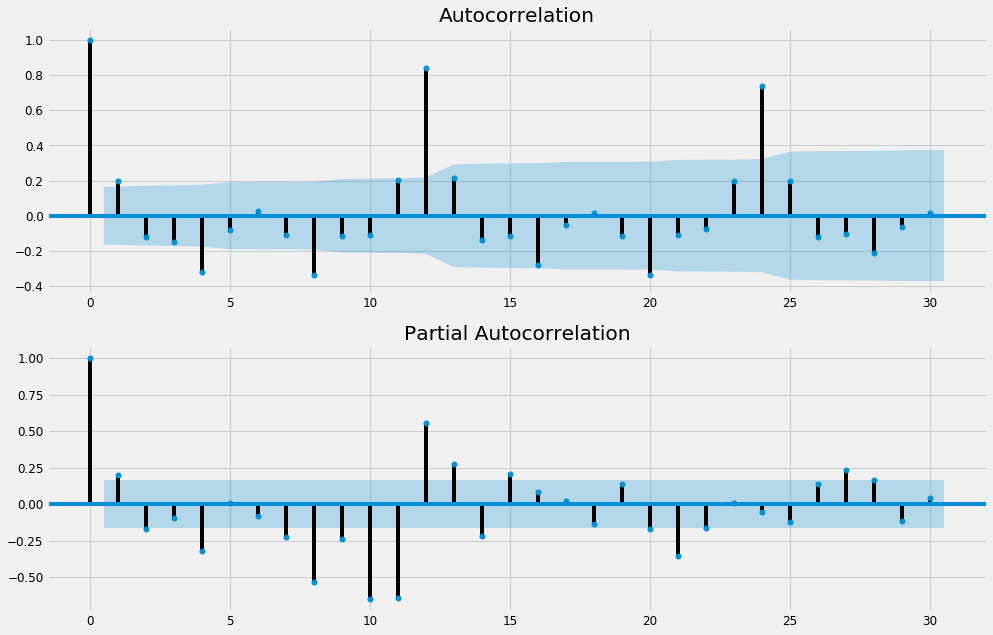

In [67]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
plot_acf(ts_log_diff, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(ts_log_diff, ax=pyplot.gca(), lags = 30)
pyplot.show()

# Time Series forecasting
[Statsmodel example notebooks](https://github.com/statsmodels/statsmodels/tree/master/examples/notebooks)

## Autoregression (AR)

In [60]:
from statsmodels.tsa.ar_model import AR
from random import random

In [72]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit(2)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      p  -                  a                  s
Model:                          AR(2)   Log Likelihood                 120.630
Method:                          cmle   S.D. of innovations              0.103
Date:                Mon, 22 Feb 2021   AIC                             -4.492
Time:                        16:18:09   BIC                             -4.409
Sample:                    02-01-1949   HQIC                            -4.458
                         - 12-01-1960                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0082      0.009      0.926      0.354      -0.009       0.025
L1.passengers     0.2350      0.084      2.794      0.005       0.070       0.400
L2.passengers    -0.1737      0.085     -2.047      0.041      -0.340      -0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6764           -2.3022j            2.3995           -0.2045
AR.2            0.6764           +2.3022j            2.3995            0.2045
-----------------------------------------------------------------------------
"""

In [78]:
model_fit


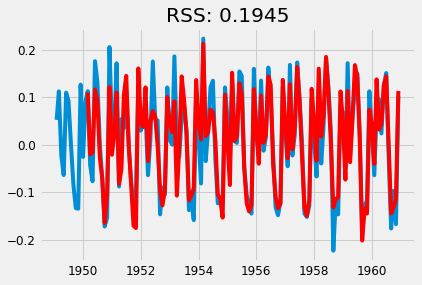

In [47]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Revirtiendo las transformaciones

__Fitted or predicted values:__

In [48]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


__Cumulative Sum to reverse differencing:__

In [49]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [50]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

__Taking Exponent to reverse Log Transform:__

In [51]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.5144')

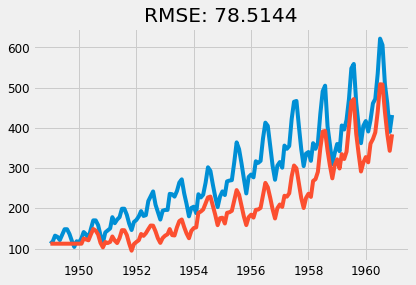

In [52]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

## Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [53]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Mon, 22 Feb 2021   AIC                           -237.507
Time:                        16:06:13   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.5245')

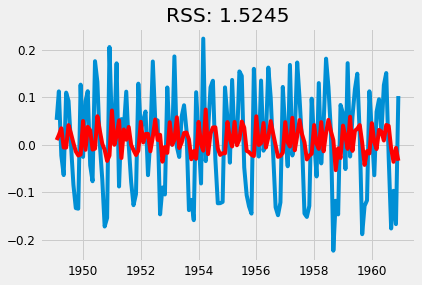

In [55]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 1.1753')

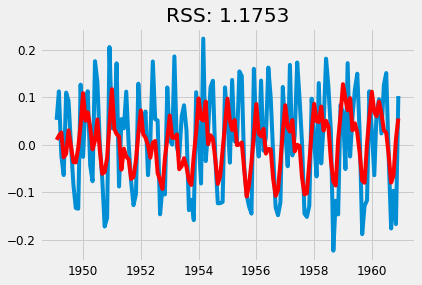

In [58]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Interpretando los gráficos de ACF


Forma ACF | Modelo indicado |
- | - |
Exponencial, decayendo a cero | Modelo autorregresivo. Utilice la gráfica de autocorrelación parcial para identificar el orden del modelo autorregresivo |
Alternancia positiva y negativa, decayendo a cero Modelo autorregresivo. | Utilice la gráfica de autocorrelación parcial para ayudar a identificar el orden. |
Uno o más picos, el resto es esencialmente cero | Modelo de promedio móvil, orden identificado por donde la parcela se vuelve cero. |
Decaimiento, comenzando después de algunos retrasos | Modelo mixto autorregresivo y de media móvil (ARMA). |
Todo cero o cercano a cero | Los datos son esencialmente aleatorios. |
Valores altos a intervalos fijos | Incluya el término autorregresivo estacional. |
Sin decadencia a cero | La serie no es estacionaria |